## Overview
Use one of fully convolutional neural networks(uNet) to segment target

Steps include (1): Parameter Configuration  (2): uNet Model Definition (3): Data Preparation (4): Training Algorithm (5): Do prediction

* It is better to divide the dataset into training, validation and testing. However, the training and validation datatset is set to be the same in this demo. All of the hyper-parameters in this demo is not tuned and it is expected to get better results when the algorithm is tuned.

* Python: 2.7
* Keras:2.2.2 
* Tensorflow: 1.6.0 (CPU-only)

## 1):  Configure Parameters

In [1]:
from __future__ import print_function,division

class Config(object):
    # image folder
    IMG_FOLDER = ''
    
    # shape of the image
    OUTPUT_SHAPE = (384,384)
    
    # base learning rate
    BASE_LR = 0.001
    
    # Batch size
    BATCH_SIZE = 4
    
    # Momentumn
    WEIGH_DECAY = 0.0005
    
    # Epoch number
    NUM_EPOCHS = 50
    
    # GPU number
    NUM_COUNT = 1
    
    # specific GPU
    WHICH_GPU = 0
    
    # IMAGE CHANNEL
    NUM_CHANNEL = 1
    
    # Number of caterogy to be predicted
    NUM_CLASSES = 2
    
    # folder used to save the trained model
    MODEL_DIR = ''
    
    # folder used to save the prediction results
    RESULTS_DIR = ''
    
    # seed
    SEED = 10
    
    def __init__(self):
        'Nonthing'
        
    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        

## 2) uNet Model Definition

In [2]:
import os
import datetime
from glob import glob
import random
import sys
import math
import cv2
import scipy

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

# print('Python       :', sys.version.split('\n')[0])
# print('Numpy        :', np.__version__)
# print('Skimage      :', skimage.__version__)
# print('Scikit-learn :', sklearn.__version__)
# print('Keras        :', keras.__version__)
# print('Tensorflow   :', tf.__version__)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def UNet(img_width=384,img_height=384):
    k_size = (3,3)
    k_init = 'he_normal'
    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (1,img_width,img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width,img_height,1)
        
    inputs = Input(shape=input_shape)
    
    #------------------Encoder: Block 1 -------------------------
    c1 = Conv2D(16,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c1)
    m1 = MaxPooling2D(pool_size=(2,2))(c1)
    
    #---------------Encoder: Block 2 -----------------------------
    c2 = Conv2D(32,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(m1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c2)
    m2 = MaxPooling2D(pool_size=(2,2))(c2)
    
    #--------------Encoder: Block 3 -------------------------------
    c3 = Conv2D(64,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(m2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c3)
    m3 = MaxPooling2D(pool_size=(2,2))(c3)
    
    #--------------Encoder: Block 4 -------------------------------
    c4 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(m3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c4)
    m4 = MaxPooling2D(pool_size=(2,2))(c4)
    
    #--------------Encoder: Block 5 -------------------------------
    c5 = Conv2D(256,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(m4)
    c5 = Dropout(0.4)(c5)
    c5 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c5)
    m5 = MaxPooling2D(pool_size=(2,2))(c5)
    
    
    c6 = Conv2D(512,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(m5)
    c6 = Dropout(0.5)(c6)
    c6 = Conv2D(512,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(c6)
    
    #================== Decoder: inv Block 5 ----------------------------
    u7 = Conv2DTranspose(filters=128, kernel_size=k_size, activation='relu',strides=(2,2), padding='same', kernel_initializer=k_init)(c6)
    u7 = concatenate([u7,c5],axis=ch_axis)
    u7 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u7)
    u7 = Dropout(0.2)(u7)
    u7 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u7)
    
    #================== Decoder: inv Block 4 ----------------------------
    u8 = Conv2DTranspose(filters=128, kernel_size=k_size, activation='relu',strides=(2,2), padding='same', kernel_initializer=k_init)(u7)
    u8 = concatenate([u8,c4],axis=ch_axis)
    u8 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u8)
    u8 = Dropout(0.2)(u8)
    u8 = Conv2D(128,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u8)

    
    #================== Decoder: inv Block 3 ----------------------------
    u9 = Conv2DTranspose(filters=64, kernel_size=k_size, activation='relu',strides=(2,2), padding='same', kernel_initializer=k_init)(u8)
    u9 = concatenate([u9,c3],axis=ch_axis)
    u9 = Conv2D(64,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u9)
    u9 = Dropout(0.2)(u9)
    u9 = Conv2D(64,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u9)

    
    #================== Decoder: inv Block 2 ----------------------------
    u10 = Conv2DTranspose(filters=32, kernel_size=k_size, activation='relu',strides=(2,2), padding='same', kernel_initializer=k_init)(u9)
    u10 = concatenate([u10,c2],axis=ch_axis)
    u10 = Conv2D(32,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u10)
    u10 = Dropout(0.1)(u10)
    u10 = Conv2D(32,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u10)
    
    #================== Decoder: inv Block 1 ----------------------------
    u11 = Conv2DTranspose(filters=16, kernel_size=k_size, activation='relu',strides=(2,2), padding='same', kernel_initializer=k_init)(u10)
    u11 = concatenate([u11,c1],axis=ch_axis)
    u11 = Conv2D(16,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u11)
    u11 = Dropout(0.1)(u11)
    u11 = Conv2D(16,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(u11)
    
    outputs = Conv2D(1, (1, 1), kernel_initializer=k_init,activation='sigmoid')(u11)
    model = Model(inputs=[inputs],outputs=[outputs])
    
    return model 

## 3) Data Preparation
Include data augmentation

In [4]:
def calculate_ave_std(img_folder):
    ave,std = [],[]
    os.chdir(img_folder)
    imgs = glob('*cimg*.png')
    
    for img_name in imgs:
        img_temp = skimage.io.imread(img_name)[:,:,0]
        ave.append(np.mean(img_temp))
        std.append(np.std(img_temp))

    return np.mean(np.array(ave)),np.mean(np.array(std))

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa


def do_augment(img,mask):
    """
    img and mask should have shape of (height, width, channels) or (N, height, width, channels)
    """
    
    seq = iaa.SomeOf(1,[
        iaa.SomeOf(1,[iaa.Affine(rotate=90,order=[0]),iaa.Affine(rotate=(-10, 10),order=[0],
                          translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})],random_order=True),
        iaa.SomeOf(1,[iaa.Fliplr(0.5),iaa.Flipud(0.5)],random_order=True),
        ])
    
    
    if np.random.uniform(0,1) > 1.0 / 20:
        seed = np.random.randint(10000)
        
        ia.seed(seed)
        img = seq.augment_image(img)
        
        ia.seed(seed)
        mask = seq.augment_image(mask)
        
    return img,mask

In [6]:
from skimage.morphology import binary_erosion
from skimage.morphology import disk

def generator(config,ave,std,has_augment=True):
    """
    generate image and its corresponding mask
    """
    os.chdir(config.IMG_FOLDER)
    train_masks = sorted(glob('*_lab*.png'))
    
    while 1:
        # extract image and mask for training
        random.shuffle(train_masks)
        num_train = len(train_masks)

        batch_size = config.BATCH_SIZE

        n_steps = int(math.floor(num_train/batch_size))
        for n_step in range(n_steps):
            train_masks_steps = train_masks[n_step * batch_size:((n_step+1)*batch_size)]  # a batch of mask image
            train_imgs_steps = ['c' + ele[1:].replace('lab','cimg') for ele in train_masks_steps] # a batch of images
            train_imgs_steps = [ele.split('_temp')[0] + '.png' for ele in train_imgs_steps]
            
            img_batch = np.zeros((batch_size,config.OUTPUT_SHAPE[0],config.OUTPUT_SHAPE[1],config.NUM_CHANNEL),dtype=np.float32)
            mask_batch = np.zeros((batch_size,config.OUTPUT_SHAPE[0],config.OUTPUT_SHAPE[1],1),dtype=np.float32)
            
            for index,img_name in enumerate(train_imgs_steps):
                img_temp = skimage.io.imread(img_name)[:,:,0]   # H*W
                mask_temp = skimage.io.imread(train_masks_steps[index]) # H*W
                
                #shrink the mask
                mask_temp = scipy.ndimage.binary_erosion(mask_temp,structure=disk(2))
                
                
                img_temp = np.array(img_temp,dtype=float)
                mask_temp = np.array(mask_temp,dtype=float)
                
                img_temp = (img_temp - ave)/std

                # resize
                img_temp = cv2.resize(img_temp,(config.OUTPUT_SHAPE[1],config.OUTPUT_SHAPE[0]),
                                       interpolation=cv2.INTER_LINEAR)
                
                mask_temp = cv2.resize(mask_temp,(config.OUTPUT_SHAPE[1],config.OUTPUT_SHAPE[0]),
                                       interpolation=cv2.INTER_NEAREST)
                
                img_temp = img_temp[...,np.newaxis]
                mask_temp = mask_temp[...,np.newaxis]

                if has_augment:
                    img_temp,mask_temp = do_augment(img_temp,mask_temp)

                img_batch[index,...] = np.array(img_temp,dtype=float)                              
                mask_batch[index,...] = np.array(mask_temp,dtype=float)

           # train_generator = zip(img_batch,mask_batch)

            yield (img_batch,mask_batch)
   

## 4) Start Training

In [7]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['mean_iou'])+1),model_history.history['mean_iou'])
    axs[0].plot(range(1,len(model_history.history['val_mean_iou'])+1),model_history.history['val_mean_iou'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['mean_iou'])+1),len(model_history.history['mean_iou'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [8]:
def mean_iou(y_true,y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [9]:
def start_train(config):
    model = UNet(img_width=config.OUTPUT_SHAPE[0],img_height=config.OUTPUT_SHAPE[1])
    #model.summary()
    
    if config.NUM_COUNT > 1:
        model = multi_gpu_model(model,gpus=config.NUM_COUNT)
    
    model.compile(optimizer='adam',loss=bce_dice_loss,metrics=[mean_iou])
    
    if not os.path.exists(config.MODEL_DIR):
        os.makedirs(config.MODEL_DIR)
        
    filepath = os.path.join(config.MODEL_DIR,'model-weights.hdf5')
    checkpoint = ModelCheckpoint(filepath,monitor='val_mean_iou',verbose=1,save_best_only=True,mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_iou', factor=0.1, patience=3, min_lr=0.00001)

    os.chdir(config.IMG_FOLDER)
    nums = len(glob('*_lab*.png'))
    
    ave,std = calculate_ave_std(config.IMG_FOLDER)
    
    train_generator = generator(config,ave,std,has_augment=True)  # Here the training dataset is also viewed as validation dataset, it is better to generate val_generator using a separate validation dataset
    val_generator = generator(config,ave,std,has_augment=False)
    model_info = model.fit_generator(train_generator, validation_data=val_generator,validation_steps=nums/config.BATCH_SIZE, steps_per_epoch=nums/config.BATCH_SIZE, epochs=config.NUM_EPOCHS, callbacks=[checkpoint,reduce_lr])

    plot_model_history(model_info)            


Configurations:
BASE_LR                        0.001
BATCH_SIZE                     4
IMG_FOLDER                     /disk2/Faliu/Keras/RBC_Segmenter/data/train_image_inner_part
MODEL_DIR                      /disk2/Faliu/Keras/RBC_Segmenter/scripts/results/train_model_watershed
NUM_CHANNEL                    1
NUM_CLASSES                    2
NUM_COUNT                      1
NUM_EPOCHS                     6
OUTPUT_SHAPE                   (384, 384)
RESULTS_DIR                    
SEED                           10
WEIGH_DECAY                    0.0005
WHICH_GPU                      0
Epoch 1/6
25/24 [==============================] - 86s 3s/step - loss: -0.1194 - mean_iou: 0.4598 - val_loss: -0.4345 - val_mean_iou: 0.5589

Epoch 00001: val_mean_iou improved from -inf to 0.55888, saving model to /disk2/Faliu/Keras/RBC_Segmenter/scripts/results/train_model_watershed/model-weights.hdf5
Epoch 2/6
25/24 [==============================] - 83s 3s/step - loss: -0.6421 - mean_iou: 0.5908 - val

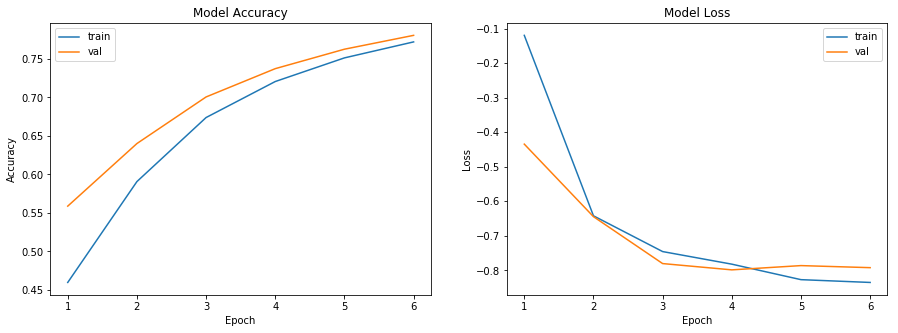

In [10]:
config = Config()
config.NUM_EPOCHS = 6
config.BASE_LR = 0.001
config.MODEL_DIR = '/disk2/Faliu/Keras/RBC_Segmenter/scripts/results/train_model_watershed'
config.IMG_FOLDER = '/disk2/Faliu/Keras/RBC_Segmenter/data/train_image_inner_part'
config.display()

start_train(config)

## 5) Do inference
Do the image prediction using the trained model

1/1 [==============================] - 0s 437ms/step


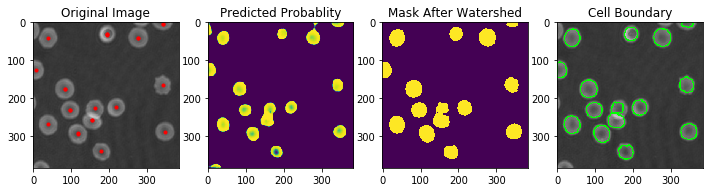

1/1 [==============================] - 0s 166ms/step


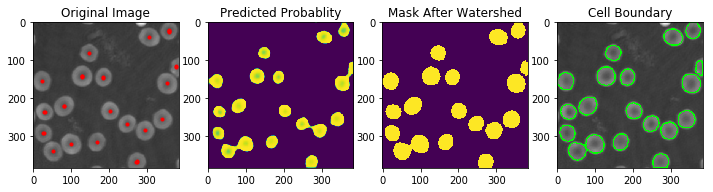

1/1 [==============================] - 0s 191ms/step


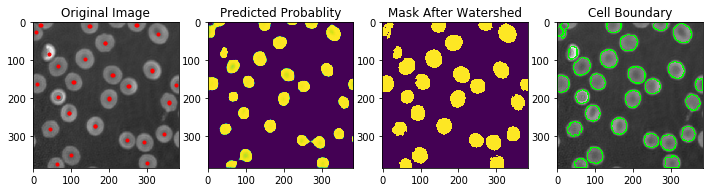

1/1 [==============================] - 0s 183ms/step


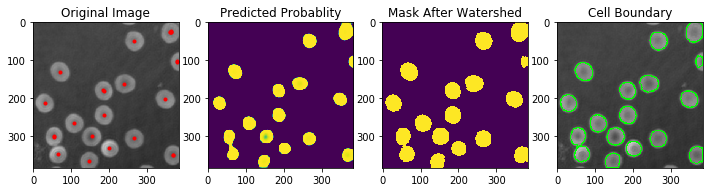

1/1 [==============================] - 0s 195ms/step


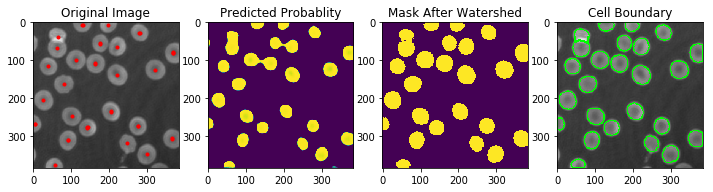

1/1 [==============================] - 0s 172ms/step


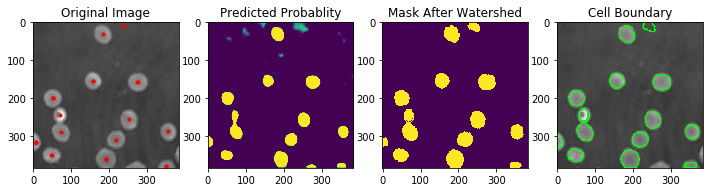

1/1 [==============================] - 0s 183ms/step


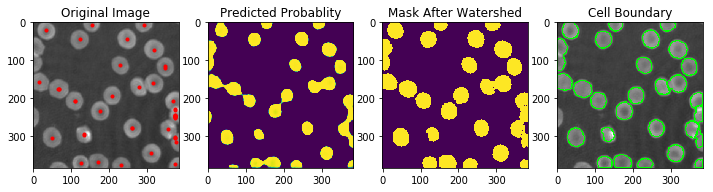

In [11]:
from skimage.morphology import binary_closing,dilation
from skimage.morphology import disk
from scipy import ndimage
from skimage.feature import peak_local_max

img_folder = '/disk2/Faliu/Keras/RBC_Segmenter/data/test_image_inner_part'

ave,std = calculate_ave_std(config.IMG_FOLDER)

model = UNet(img_width=config.OUTPUT_SHAPE[0],img_height=config.OUTPUT_SHAPE[1])
model.load_weights(config.MODEL_DIR + os.sep + 'model-weights.hdf5')

os.chdir(img_folder)
imgs = glob('*cimg*.png')
for img_name in imgs:
    oriImg = skimage.io.imread(img_name)
    img = (np.array(oriImg[:,:,0],dtype=float) - ave) / std
    
    img = cv2.resize(img,(config.OUTPUT_SHAPE[1],config.OUTPUT_SHAPE[0]),
                     interpolation=cv2.INTER_LINEAR)
    temp = img[np.newaxis,...,np.newaxis]
    pred = model.predict(temp, verbose=1)
    
    bin_img = np.squeeze(pred) > 0.5
    bin_img = scipy.ndimage.binary_fill_holes(bin_img).astype(int)
    bin_img = scipy.ndimage.binary_opening(bin_img, structure=disk(6)).astype(np.uint8)
    
    
    # watershed processing
    dist_transform = cv2.distanceTransform(bin_img,cv2.DIST_L2,5)
    coordinates = peak_local_max(dist_transform,min_distance=5)
    
    local_max = np.zeros(img.shape)
    local_max[coordinates[:,0],coordinates[:,1]] = 1
    local_max = dilation(local_max,disk(9))
    
    # markers
    ret,markers = cv2.connectedComponents(bin_img)
    max_label = np.max(markers)
    
    isolated_area = np.zeros(img.shape)
  #  connected_area = np.zeros(img.shape)
    connected_area_markers = np.zeros(img.shape)
    for index in range(max_label):
        temp = markers == index + 1
        temp_region = temp * local_max
        ret_temp,markers_temp = cv2.connectedComponents(temp_region.astype(np.uint8))
        if np.max(markers_temp) > 1:
          #  connected_area = connected_area + temp
            connected_area_markers = connected_area_markers + temp_region
        else:
            isolated_area = isolated_area + temp
    
    inner_markers = isolated_area + connected_area_markers
    sure_bg = dilation(bin_img,disk(6))
    unknown = cv2.subtract(sure_bg.astype(np.uint8),inner_markers.astype(np.uint8))

    
    ret2,markers2 = cv2.connectedComponents(inner_markers.astype(np.uint8))
    markers2 = markers2 + 1
    markers2[unknown==1] = 0
    
    markers2 = cv2.watershed(oriImg,markers2)
    final_mask = markers2 > 1


    oriImg2 = np.copy(oriImg)
    im2, contours, hierarchy = cv2.findContours(final_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(oriImg2,contours, -1, (0, 255 , 0), 2)

    # draw images
    f = plt.figure(figsize=(12,50))
    ax1 = f.add_subplot(1,4,1)
    plt.imshow(oriImg)
    ax1.plot(coordinates[:,1],coordinates[:,0],'r.')
    ax2 = f.add_subplot(1,4,2)
    plt.imshow(np.squeeze(pred))
    ax3 = f.add_subplot(1,4,3)
    plt.imshow(final_mask)
    ax4 = f.add_subplot(1,4,4)
    plt.imshow(oriImg2)
    
    ax1.title.set_text('Original Image')
    ax2.title.set_text('Predicted Probablity')
    ax3.title.set_text('Mask After Watershed')
    ax4.title.set_text('Cell Boundary')

    plt.show()